In [78]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
df = pd.read_csv('../data/clean_dataset.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065137 entries, 0 to 1065136
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Name          1065137 non-null  object 
 1   Authors       1065137 non-null  object 
 2   PublishYear   1065137 non-null  int64  
 3   Publisher     1065137 non-null  object 
 4   Rating        1065137 non-null  float64
 5   PagesNumber   1065137 non-null  float64
 6   TotalReviews  1065137 non-null  int64  
 7   Description   1065137 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 73.1+ MB


## Define y_target and split train/test dataset

In [17]:
REVIEWS_THRESHOLD = 500
print(f'Proportion of popular books in the dataset: {round((df.TotalReviews > REVIEWS_THRESHOLD).sum() / df.index.size, 2)}')
(df.TotalReviews > REVIEWS_THRESHOLD).sum()

Proportion of popular books in the dataset: 0.07


75122

In [19]:
input_columns = [column for column in df.columns if column != 'TotalReviews']
X, y = df[input_columns], df.TotalReviews > REVIEWS_THRESHOLD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Fit and Evaluation functions

We want to maximise for precision, given that a False Positive may be too costly for us.

In [26]:
def train_evaluate_model(model, X_train=None, y_train=None, X_test=None, y_test=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred)

## Model training and evaluation
### DummyModel

In [28]:
dummy_regressor = DummyClassifier()
print(train_evaluate_model(dummy_regressor,
                     X_train=X_train,
                     y_train=y_train,
                     X_test=X_test,
                     y_test=y_test))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.00      0.00      0.00      7673

    accuracy                           0.93    106514
   macro avg       0.46      0.50      0.48    106514
weighted avg       0.86      0.93      0.89    106514



/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-

### Ordinary Least Squares

In [30]:
lr = linear_model.LogisticRegression()
report = train_evaluate_model(lr,
                     X_train=X_train[['PublishYear', 'PagesNumber']],
                     y_train=y_train,
                     X_test=X_test[['PublishYear', 'PagesNumber']],
                     y_test=y_test)

print(report)

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.00      0.00      0.00      7673

    accuracy                           0.93    106514
   macro avg       0.46      0.50      0.48    106514
weighted avg       0.86      0.93      0.89    106514



In [31]:
lr.coef_

array([[-0.00133099,  0.00028371]])

## CountVectorizer

In [32]:
vectorizer = CountVectorizer(stop_words={'english'},
                             max_df=0.05,
                             min_df=50)

In [33]:
vectorizer.fit(X_train['Description'])

CountVectorizer(max_df=0.05, min_df=50, stop_words={'english'})

In [34]:
len(vectorizer.vocabulary_)

44659

In [35]:
X_train_vec = vectorizer.transform(X_train['Description'])

In [38]:
X_test_vec = vectorizer.transform(X_test['Description'])

In [38]:
X_train_vec

<1085866x47422 sparse matrix of type '<class 'numpy.int64'>'
	with 54669218 stored elements in Compressed Sparse Row format>

In [39]:
lr = linear_model.LogisticRegression()
report = train_evaluate_model(lr,
    X_train=X_train_vec,
    y_train=y_train,
    X_test=X_test_vec,
    y_test=y_test)
print(report)

              precision    recall  f1-score   support

       False       0.95      0.98      0.96     98841
        True       0.54      0.27      0.36      7673

    accuracy                           0.93    106514
   macro avg       0.74      0.62      0.66    106514
weighted avg       0.92      0.93      0.92    106514



/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
y_pred = lr.predict(X_test_vec)
y_pred_proba = lr.predict_proba(X_test_vec)

In [64]:
y_pred[:5]

array([False, False, False, False, False])

In [65]:
y_pred_proba[:5]

array([[9.97948897e-01, 2.05110264e-03],
       [9.56454324e-01, 4.35456764e-02],
       [9.92235774e-01, 7.76422636e-03],
       [9.99796340e-01, 2.03660313e-04],
       [9.01531646e-01, 9.84683535e-02]])

In [71]:
y_pred_test1 = y_pred_proba[:,1] > 0.9

In [68]:
lr.classes_

array([False,  True])

In [72]:
print(classification_report(y_test, y_pred_test1))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.69      0.08      0.15      7673

    accuracy                           0.93    106514
   macro avg       0.81      0.54      0.56    106514
weighted avg       0.92      0.93      0.91    106514



/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


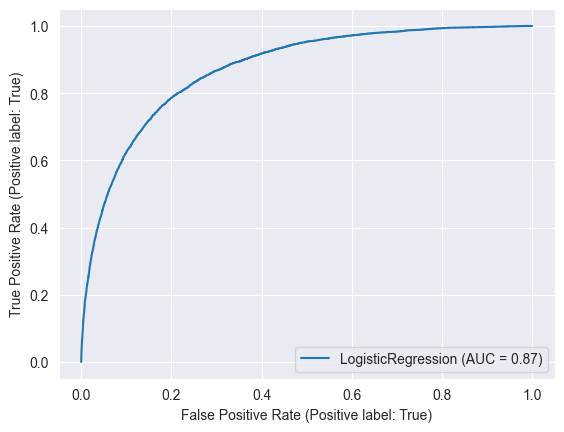

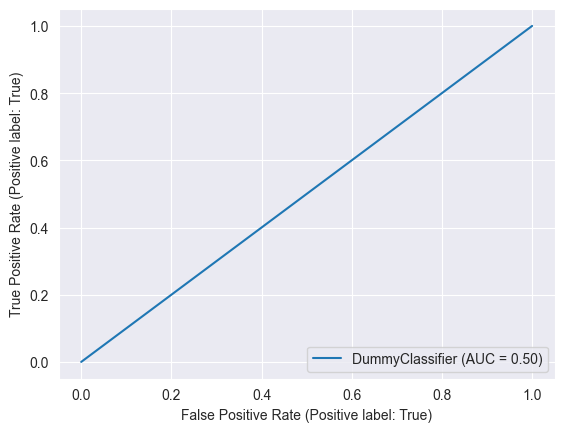

In [73]:
plot_roc_curve(lr, X_test_vec, y_test)
plot_roc_curve(dummy_regressor, X_test_vec, y_test)

Let's introduce Scikit Learn Pipelines

In [82]:
column_trans = ColumnTransformer([
    ('description_bow', CountVectorizer(stop_words={'english'},
                             max_df=0.05,
                             min_df=50), 'Description'),
    ('title_bow', CountVectorizer(stop_words={'english'},
                             max_df=0.05,
                             min_df=50), 'Name')
])
model = Pipeline([
    ('vectorize', column_trans),
    ('classify', linear_model.LogisticRegression()),
])

In [ ]:
train_evaluate_model(model,
                     X_train=X_train,
                     y_train=y_train,
                     X_test=X_test,
                     y_test=y_test)

In [81]:
print(_)

              precision    recall  f1-score   support

       False       0.95      0.98      0.96     98841
        True       0.54      0.27      0.36      7673

    accuracy                           0.93    106514
   macro avg       0.74      0.62      0.66    106514
weighted avg       0.92      0.93      0.92    106514

